In [1]:
import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1000)
np.random.seed(1000)

parser = argparse.ArgumentParser('ODE demo')
parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000)
parser.add_argument('--batch_time', type=int, default=15)
parser.add_argument('--batch_size', type=int, default=50)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')

# Parse arguments when running in Jupyter notebook
args = parser.parse_args(args=[])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')



In [2]:
## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncMean(nn.Module):

    def __init__(self):
        super(ODEFuncMean, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        ).to(torch.float64)

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcMean = ODEFuncMean().to(device)

## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncVariance(nn.Module):

    def __init__(self):
        super(ODEFuncVariance, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcVariance = ODEFuncVariance().to(device)

## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncSkewness(nn.Module):

    def __init__(self):
        super(ODEFuncSkewness, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcSkewness = ODEFuncSkewness().to(device)

## Construct a neural network to approximate the dynamics of an ODE
class ODEFuncKurtosis(nn.Module):

    def __init__(self):
        super(ODEFuncKurtosis, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)
    
funcKurtosis = ODEFuncKurtosis().to(device)

In [3]:
funcMeanLoaded = torch.load('mean.pth')
funcSkwLoaded = torch.load('skewness.pth')
funcVarLoaded = torch.load('variance.pth')
funcKurtLoaded = torch.load('kurtosis.pth')

In [4]:
    
def combined_system_mean(tVar, y):   
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])
    
    dm_dt = funcMeanLoaded(tVar, y)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
    
    ds_dt = ds_dt_fun(tVar.item()).item()
    ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

def combined_system_var(tVar, y):   
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])

    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = funcVarLoaded(tVar, y)
        
    ds_dt = ds_dt_fun(tVar.item()).item()
    ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

def combined_system_skw(tVar, y):   
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])

    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
        
    ds_dt = funcSkwLoaded(tVar,y)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

def combined_system_kurt(tVar, y):   
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])

    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = dv_dt_fun(tVar.item()).item()
    dv_dt = torch.tensor([dv_dt]).to(dtype=torch.double)
        
    ds_dt = ds_dt_fun(tVar.item()).item()
    ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)
    
    dk_dt = funcKurtLoaded(tVar,y)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

matrix= scipy.io.loadmat("/home/ponnana/PhD/Yinling_copy/data_new.mat")

m = matrix["data_new"][:,0]
v =  matrix["data_new"][:,1]
s = matrix["data_new"][:,2]
k = matrix["data_new"][:,3]

tExp = [0.01058, 0.03158, 0.05258, 0.07358, 0.09458, 0.1156, 0.1366, 0.1576, 0.1786, 0.1996, 0.2206,
          0.2300, 0.2756, 0.3316, 0.3876, 0.4436, 0.4496, 0.5556, 0.6116, 0.6676, 0.7206, 0.7796, 0.8356,
          0.8916, 0.9476, 1.004, 1.060, 1.105, 1.124, 1.153, 1.182, 1.211, 1.240, 1.269, 1.298, 1.327,
          1.356, 1.385, 1.414, 1.443, 1.472, 1.501, 1.530, 1.559, 1.588, 1.617, 1.646, 1.670]

tExp = np.array(tExp)


t1,t2 = 0.24,1.1
xExp = np.concatenate((matrix["data_new"], tExp.reshape(-1,1)), axis=1)
# xExp = xExp.astype(double)

In [6]:
maxValues = np.max(xExp,axis=0)
maxValues[-1]=1
xExpNormal = xExp/maxValues
truncIndex = np.where(xExpNormal[:,1]>=0.0999)
xExpTruncNormal = xExpNormal[truncIndex,:]
xExpTruncNormal = np.squeeze(xExpTruncNormal)

tExpTrunc = xExpTruncNormal[:,-1]

In [7]:
from scipy.interpolate import interp1d
tTrain = np.linspace(np.min(tExpTrunc), np.max(tExpTrunc), args.data_size)
quad_interp = interp1d(tExpTrunc, xExpTruncNormal, kind='quadratic', axis=0)
xTrain = quad_interp(tTrain) 

In [12]:
dmeanBydtTemp = xTrain[1:,0]-xTrain[0:-1,0]
dvarBydtTemp = xTrain[1:,1]-xTrain[0:-1,1]
dskwBydtTemp = xTrain[1:,2]-xTrain[0:-1,2]
dkurtBydtTemp = xTrain[1:,3]-xTrain[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

In [13]:
clear true_y 

In [14]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrain[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrain).unsqueeze(1).to(dtype=torch.double)

In [15]:
with torch.no_grad():
    predicted_states_1 = odeint(combined_system_mean, true_y0, t).to(device)
    predicted_states_2 = odeint(combined_system_var, true_y0, t).to(device)
    predicted_states_3 =  odeint(combined_system_skw, true_y0, t).to(device)
    predicted_states_4 =  odeint(combined_system_kurt, true_y0, t).to(device)

predicted_states_1 = predicted_states_1.numpy()
predicted_states_2 = predicted_states_2.numpy()
predicted_states_3 = predicted_states_3.numpy()
predicted_states_4 = predicted_states_4.numpy()

In [16]:
trainMean = predicted_states_1[:,0]
trainVar =  predicted_states_2[:,1]
trainSkw =  predicted_states_3[:,2]
trainKurt = predicted_states_4[:,3]

In [17]:
xTrainNew = np.column_stack((trainMean,trainVar,trainSkw,trainKurt, tTrain))

In [18]:
dmeanBydtTemp = xTrainNew[1:,0]-xTrainNew[0:-1,0]
dvarBydtTemp = xTrainNew[1:,1]-xTrainNew[0:-1,1]
dskwBydtTemp = xTrainNew[1:,2]-xTrainNew[0:-1,2]
dkurtBydtTemp = xTrainNew[1:,3]-xTrainNew[0:-1,3]
timeStep= tTrain[1]-tTrain[0]

dmeanBydtTemp = dmeanBydtTemp/timeStep
dvarBydtTemp = dvarBydtTemp/timeStep
dskwBydtTemp = dskwBydtTemp/timeStep
dkurtBydtTemp = dkurtBydtTemp/timeStep

dmeanBydt = np.append(dmeanBydtTemp,dmeanBydtTemp[-1])
dvarBydt = np.append(dvarBydtTemp,dvarBydtTemp[-1])
dskwBydt = np.append(dskwBydtTemp,dskwBydtTemp[-1])
dkurtBydt = np.append(dkurtBydtTemp,dkurtBydtTemp[-1])

dm_dt_fun = interp1d(tTrain, dmeanBydt, axis=0, fill_value='extrapolate')
dv_dt_fun = interp1d(tTrain, dvarBydt, axis=0, fill_value='extrapolate')
ds_dt_fun = interp1d(tTrain, dskwBydt, axis=0, fill_value='extrapolate')
dk_dt_fun = interp1d(tTrain, dkurtBydt, axis=0, fill_value='extrapolate')

In [21]:
## Setting up the true system
true_y0 = torch.from_numpy(xTrainNew[0,:]).to(device).to(dtype=torch.double)
t = torch.from_numpy(tTrain).to(dtype=torch.double)
true_y = torch.from_numpy(xTrainNew).unsqueeze(1).to(dtype=torch.double)

In [22]:
## Get mini-batch data from the training dataset 
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = torch.stack([t[i:i+args.batch_time] for i in s]) # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=1)  # (T, M, D)
    batch_y=batch_y.permute(2,0,1,3)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

In [23]:
def combined_system(tVar, y):    
    dt_dt = 1.0
    dt_dt = torch.tensor([dt_dt])

    dm_dt = dm_dt_fun(tVar.item()).item()
    dm_dt = torch.tensor([dm_dt]).to(dtype=torch.double)
    
    dv_dt = funcVarLoaded(tVar, y)
       
    ds_dt = ds_dt_fun(tVar.item()).item()
    ds_dt = torch.tensor([ds_dt]).to(dtype=torch.double)
    
    dk_dt = dk_dt_fun(tVar.item()).item()
    dk_dt = torch.tensor([dk_dt]).to(dtype=torch.double)
    
    return torch.cat([dm_dt, dv_dt, ds_dt, dk_dt, dt_dt], dim=0)

In [27]:
ii = 0
## Setting up the optimizer

# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(funcVarLoaded.parameters(), lr=0.005)

for itr in range(1, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,1].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,1]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,1].unsqueeze(1)
                actual_toDisplay = true_y[:,:,1]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0001 | Total Loss 1.011194
Iter 0020 | Total Loss 0.210347
Iter 0040 | Total Loss 0.149874
Iter 0060 | Total Loss 0.197353
Iter 0080 | Total Loss 0.176407
Iter 0100 | Total Loss 0.138536
Iter 0120 | Total Loss 0.113308
Iter 0140 | Total Loss 0.022811
Iter 0160 | Total Loss 0.035184
Iter 0180 | Total Loss 0.088535
Iter 0200 | Total Loss 0.041052
Iter 0220 | Total Loss 0.017971
Iter 0240 | Total Loss 0.074620
Iter 0260 | Total Loss 0.100658


KeyboardInterrupt: 

In [28]:
# Setting up the optimizer with all parameters
optimizer = optim.RMSprop(funcVarLoaded.parameters(), lr=0.00005)

for itr in range(280, args.niters + 1):
#for itr in range(1, 20):
        ## Using mini-batch data to update the neural network coefficients
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        solutions = []
        temp1 = 0
        for ic in batch_y0:
            sol = odeint(combined_system, ic[0], batch_t[temp1])
            solutions.append(sol)
            temp1 = temp1+1
        pred_toCalcLoss= torch.stack(solutions)[:,:,1].unsqueeze(0)
        actual_toCalcLoss = batch_y[:,:,:,1]
        #pred_y = pred_y.permute(2, 1, 0, 3)
        loss = torch.mean(torch.abs(pred_toCalcLoss - actual_toCalcLoss))
        loss.backward()
        optimizer.step()

        if itr % args.test_freq == 0 or itr == 1:
            with torch.no_grad():
                pred_y = odeint(combined_system, true_y0, t)
                pred_toDisplay = pred_y[:,1].unsqueeze(1)
                actual_toDisplay = true_y[:,:,1]
                loss = torch.mean(torch.abs(pred_toDisplay - actual_toDisplay))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                ii += 1

Iter 0280 | Total Loss 0.055673
Iter 0300 | Total Loss 0.014247
Iter 0320 | Total Loss 0.006988
Iter 0340 | Total Loss 0.007066
Iter 0360 | Total Loss 0.007266
Iter 0380 | Total Loss 0.007166
Iter 0400 | Total Loss 0.007515
Iter 0420 | Total Loss 0.006910
Iter 0440 | Total Loss 0.008889
Iter 0460 | Total Loss 0.006982
Iter 0480 | Total Loss 0.007311
Iter 0500 | Total Loss 0.008394
Iter 0520 | Total Loss 0.008399
Iter 0540 | Total Loss 0.008610
Iter 0560 | Total Loss 0.007489
Iter 0580 | Total Loss 0.007071
Iter 0600 | Total Loss 0.008219
Iter 0620 | Total Loss 0.006937
Iter 0640 | Total Loss 0.009700
Iter 0660 | Total Loss 0.012428
Iter 0680 | Total Loss 0.007383
Iter 0700 | Total Loss 0.006846
Iter 0720 | Total Loss 0.011005
Iter 0740 | Total Loss 0.007486
Iter 0760 | Total Loss 0.008319
Iter 0780 | Total Loss 0.006863
Iter 0800 | Total Loss 0.008863
Iter 0820 | Total Loss 0.008852
Iter 0840 | Total Loss 0.008049
Iter 0860 | Total Loss 0.010220
Iter 0880 | Total Loss 0.007306
Iter 090

KeyboardInterrupt: 

In [29]:
y0 = true_y0
#y0= torch.tensor([ 0,  0.5, 0, 0])

# Time point for prediction
t_value = t
with torch.no_grad():
    predicted_states = odeint(combined_system,y0 , t).to(device)

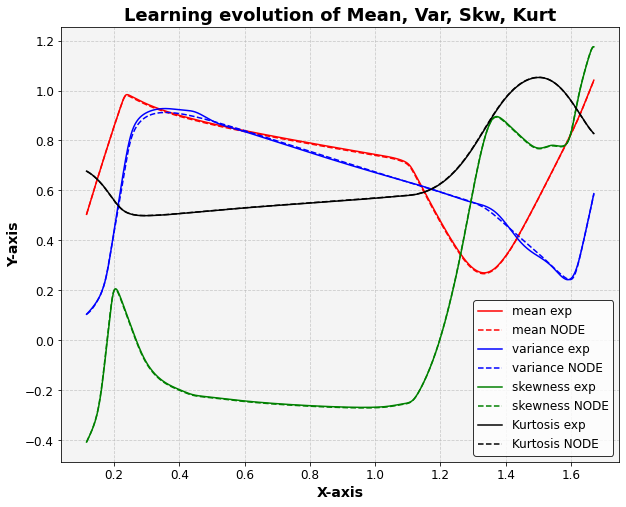

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(tTrain,xTrainNew[:,0], 'r',label='mean exp')
plt.plot(tTrain,predicted_states[:,0], 'r--',label='mean NODE')

plt.plot(tTrain,xTrainNew[:,1], 'b',label='variance exp')
plt.plot(tTrain,predicted_states[:,1], 'b--',label='variance NODE')

plt.plot(tTrain,xTrainNew[:,2], 'g',label='skewness exp')
plt.plot(tTrain,predicted_states[:,2], 'g--',label='skewness NODE')

plt.plot(tTrain,xTrainNew[:,3], 'k',label='Kurtosis exp')
plt.plot(tTrain,predicted_states[:,3], 'k--',label='Kurtosis NODE')

ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

# Customize fonts and sizes
ax.set_title("Learning evolution of Mean, Var, Skw, Kurt", fontsize=18, fontweight='bold')
ax.set_xlabel("X-axis", fontsize=14, fontweight='bold')
ax.set_ylabel("Y-axis", fontsize=14, fontweight='bold')

# Increase tick label font size
ax.tick_params(axis='both', labelsize=12)

# Customize the appearance of the legend
legend = ax.legend(loc='lower right', fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.set_facecolor('#F4F4F4')

plt.savefig('NN_var_all_parts_2.pdf', bbox_inches='tight')

# Show the plot
plt.show()


In [33]:
torch.save(funcVarLoaded, 'varianceFromNN.pth')